Import required libraries

In [15]:
import pandas as pd
import numpy as np


Load your dataset

In [16]:
df = pd.read_csv("patient_adverse_drug_reactions.csv")
df.head()


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,...,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove unwanted columns

In [17]:
df = df.loc[:, ~df.columns.str.contains("Unnamed")]


Select important columns

In [18]:
df = df[
    [
        "drug_name",
        "medical_condition",
        "drug_classes",
        "rx_otc",
        "pregnancy_category",
        "rating",
        "no_of_reviews"
    ]
]


Handle missing values

In [19]:
# Convert numeric columns safely (important fix)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["no_of_reviews"] = pd.to_numeric(df["no_of_reviews"], errors="coerce")

# Fill missing categorical values
df["drug_classes"] = df["drug_classes"].fillna("Unknown")
df["pregnancy_category"] = df["pregnancy_category"].fillna("N")

# Fill missing numeric values
df["rating"] = df["rating"].fillna(df["rating"].mean())
df["no_of_reviews"] = df["no_of_reviews"].fillna(0)


Create TARGET VARIABLE

In [20]:
def create_safety_risk(row):
    if row["pregnancy_category"] in ["D", "X"]:
        return 1
    elif row["rating"] < 6:
        return 1
    else:
        return 0

df["safety_risk"] = df.apply(create_safety_risk, axis=1)


Encode categorical features

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_cols = [
    "drug_name",
    "medical_condition",
    "drug_classes",
    "rx_otc",
    "pregnancy_category"
]

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


Split features and target

In [22]:
X = df.drop("safety_risk", axis=1)
y = df["safety_risk"]


Train–Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


TRAIN ML MODELS

Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


Random Forest (main model)

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


Import metrics

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


Metrics for Logistic Regression

In [27]:
# Accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)

# Precision, Recall, F1
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Metrics")
print("Accuracy :", acc_lr)
print("Precision:", prec_lr)
print("Recall   :", rec_lr)
print("F1-score :", f1_lr)


Logistic Regression Metrics
Accuracy : 0.8703703703703703
Precision: 0.8114754098360656
Recall   : 0.6470588235294118
F1-score : 0.72


Metrics for Random Forest

In [28]:
# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)

# Precision, Recall, F1
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Metrics")
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1-score :", f1_rf)


Random Forest Metrics
Accuracy : 0.9983164983164983
Precision: 0.9935064935064936
Recall   : 1.0
F1-score : 0.996742671009772


Detailed classification report

In [29]:
print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       441
           1       0.81      0.65      0.72       153

    accuracy                           0.87       594
   macro avg       0.85      0.80      0.82       594
weighted avg       0.87      0.87      0.87       594



Random Forest

In [30]:
print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))


Random Forest Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       0.99      1.00      1.00       153

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594



Confusion Matrix

In [31]:
print("Confusion Matrix - Random Forest")
print(confusion_matrix(y_test, y_pred_rf))


Confusion Matrix - Random Forest
[[440   1]
 [  0 153]]


GRAPHS & CHARTS FOR MODEL EVALUATION

Confusion Matrix (Random Forest)

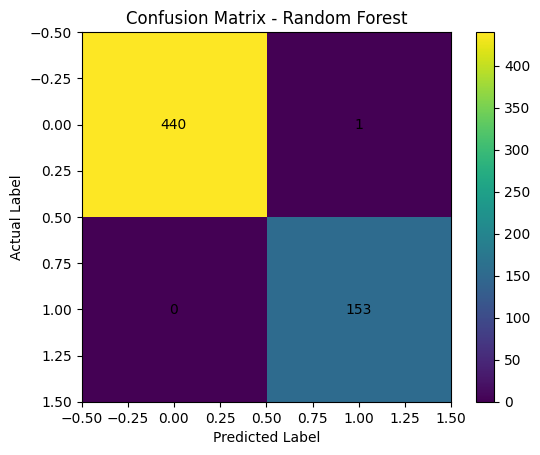

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.colorbar()

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


Bar Chart: Accuracy Comparison (LR vs RF)

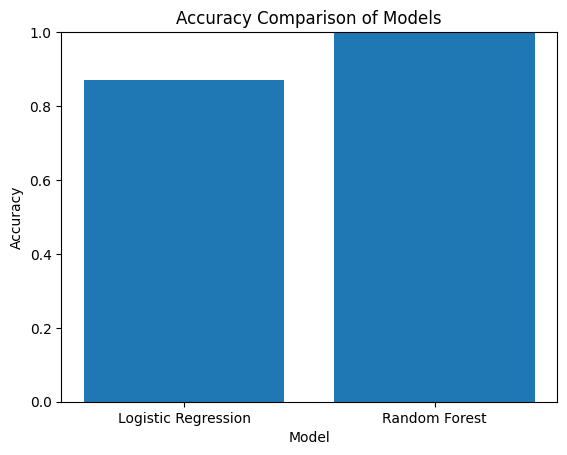

In [33]:
models = ["Logistic Regression", "Random Forest"]
accuracy = [acc_lr, acc_rf]

plt.figure()
plt.bar(models, accuracy)
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()


Precision, Recall, F1 Comparison Chart

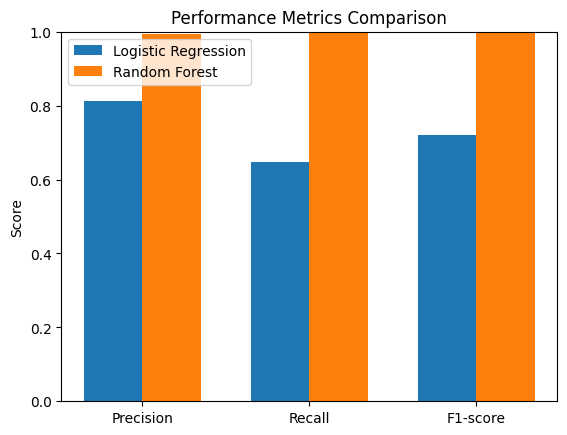

In [34]:
import numpy as np

metrics = ["Precision", "Recall", "F1-score"]
lr_scores = [prec_lr, rec_lr, f1_lr]
rf_scores = [prec_rf, rec_rf, f1_rf]

x = np.arange(len(metrics))
width = 0.35

plt.figure()
plt.bar(x - width/2, lr_scores, width, label="Logistic Regression")
plt.bar(x + width/2, rf_scores, width, label="Random Forest")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Metrics Comparison")
plt.legend()
plt.ylim(0, 1)
plt.show()


Class Distribution Chart

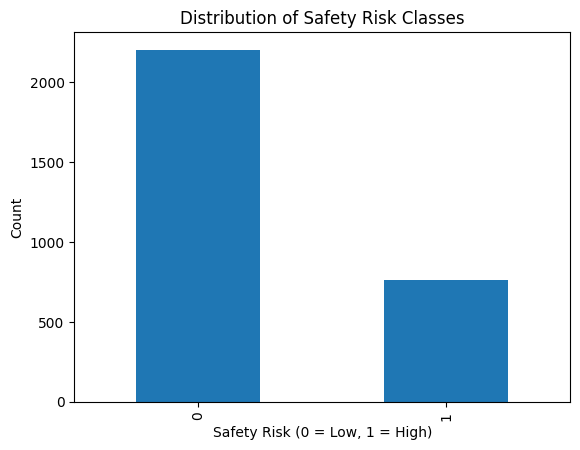

In [35]:
df["safety_risk"].value_counts().plot(kind="bar")
plt.title("Distribution of Safety Risk Classes")
plt.xlabel("Safety Risk (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.show()


Feature Importance (Random Forest)

In [36]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance


,Feature,Importance
5,rating,0.480695
4,pregnancy_category,0.305838
6,no_of_reviews,0.075127
2,drug_classes,0.054878
1,medical_condition,0.035746
0,drug_name,0.029332
3,rx_otc,0.018384


Plot Feature Importance

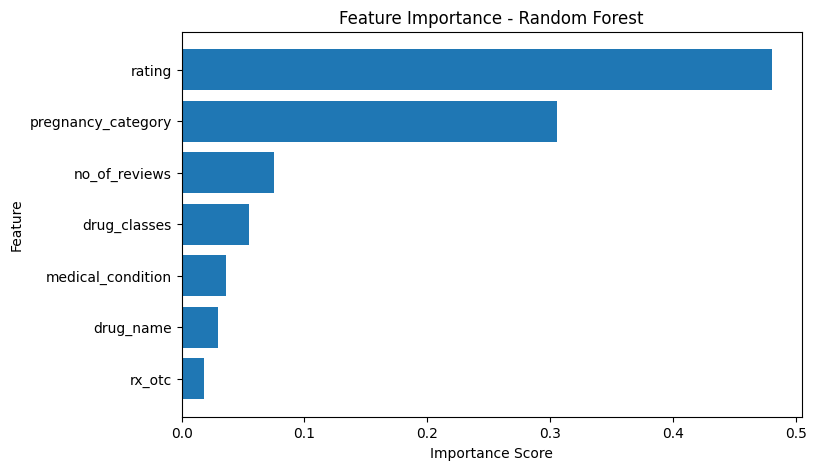

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()


Explain ONE prediction (Human-style)

In [38]:
sample = X_test.iloc[0]
prediction = rf.predict([sample])[0]

print("Prediction:", "High Risk" if prediction == 1 else "Low Risk")
print("Important factors:")
print(feature_importance.head(3))


Prediction: Low Risk
Important factors:
              Feature  Importance
5              rating    0.480695
4  pregnancy_category    0.305838
6       no_of_reviews    0.075127


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SAVE TRAINED ML MODEL

Import joblib

In [39]:
import joblib


Create a folder to store models

In [40]:
import os

os.makedirs("models", exist_ok=True)


Save the trained Random Forest model

In [41]:
joblib.dump(rf, "models/random_forest_patient_safety.pkl")


['models/random_forest_patient_safety.pkl']

Save the Label Encoder(s)

In [42]:
joblib.dump(le, "models/label_encoder.pkl")


['models/label_encoder.pkl']